In [1]:
import numpy as np
import pandas as pd
import networkx 
import torch
from networkx import karate_club_graph, to_numpy_matrix
%matplotlib inline

### GCN CONCEPT
Graphical Convolutional Network is a NN layer for graph-like structures to compute n-dimensional feature representation of Nodes in Graph.

Below is a toy example to wrap our heads around the concept.

In [6]:
#Adjacency Matrix of a 4-node graph
A = torch.FloatTensor([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]])

Adjacency matrix is a 

This matrix will be essentially used as a templete for selecting other nodes related to given node. So unless a node have a self loop it will in itself never be selected to feature aggregation. Thats why we have to add self loops so that each node features can be used to generate its own representation.

In [7]:
#Identity Matrix of the same shape as A
I = torch.eye(A.shape[0])
#we are adding I to A so that A_hat can be used to combine features of a node with a feature of its neighbors (we add self loops essentially)
A_hat = A+I
print(A_hat)

tensor([[1., 1., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 1.]])


Since degree level of nodes will impact how many nodes are used tocalculate final representation we have to normalize it some way.

In [261]:
#Degree matrix
D = np.array(np.sum(A_hat, axis=0))[0]
D = np.matrix(np.diag(D))
print(D)

[[2. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 2.]]


Lets generate some "features" to act as input. Those could be one-hot encoded id of each node, or some features coming from your dataset (number of shop visits, shirt color, etc)

In [262]:
#nodes features
#shape = 4 (nodes), 2 (num of features)
X = np.matrix([
    [i, -i]
    for i in range(A.shape[0])
], dtype=float)
print(X)

[[ 0.  0.]
 [ 1. -1.]
 [ 2. -2.]
 [ 3. -3.]]


Last thing we need are some weights. Weights in GCN layer are used to 

In [264]:
#weights
#shape = 2 (number of input features), 3 (number of output features)
W = np.matrix([
     [1, -0.9, 0.7],
     [-1, 0.5, 0.5]
])

In [15]:
#linear activation
#shape = 4 (nodes), 3 (num of output features from W)
y = D**-1 * A_hat * X * W

#relu
y[y<0]=0

print('X\n',X)
print('Y\n',y)

X
 [[ 0.  0.]
 [ 1. -1.]
 [ 2. -2.]
 [ 3. -3.]]
Y
 [[1.  0.  0.1]
 [4.  0.  0.4]
 [2.  0.  0.2]
 [5.  0.  0.5]]


In [29]:
print(D**-1 * A_hat * X,'\n\n', W, '\n\n', D**-1 * A_hat * X * W)

[[ 0.5 -0.5]
 [ 2.  -2. ]
 [ 1.  -1. ]
 [ 2.5 -2.5]] 

 [[ 1.  -0.9  0.7]
 [-1.   0.5  0.5]] 

 [[ 1.  -0.7  0.1]
 [ 4.  -2.8  0.4]
 [ 2.  -1.4  0.2]
 [ 5.  -3.5  0.5]]


In [100]:
def GCN_forward(A, X, W):
    # calculate leaky_relu(D**-1 * A_hat * X * W)
    # based on https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780
    I = np.matrix(np.eye(A.shape[0]))
    A_hat = A+I
    D = np.array(np.sum(A_hat, axis=0))[0]
    D = np.matrix(np.diag(D))
    y = D**-1 * A_hat * X * W
    y = np.where(y > 0, y, y * 0.05) 
    return y

In [80]:
GCN_forward(A, X, W)

array([[ 1.   , -0.035,  0.1  ],
       [ 4.   , -0.14 ,  0.4  ],
       [ 2.   , -0.07 ,  0.2  ],
       [ 5.   , -0.175,  0.5  ]])

In [99]:
W1 = np.random.normal(loc=0, scale=1, size=(X.shape[1], 4))
W2 = np.random.normal(loc=0, size=(W1.shape[1], 2))
print(W1,'\n\n',W2)

[[-0.24076763  0.44969968 -0.68178031  0.25269822]
 [ 1.67794053 -1.42997133  0.40414433  0.74126436]] 

 [[-0.97310815  0.16076893]
 [ 1.70313786  0.37593033]
 [-0.9374675   1.06367053]
 [ 0.49469533 -1.5200449 ]]


In [82]:
GCN_L1 = GCN_forward(A, X, W1)
GCN_L2 = GCN_forward(A, GCN_L1, W2)
print(GCN_L2)

[[ 1.00108179 -0.24328801]
 [ 1.46825329 -0.35682241]
 [ 0.80086543 -0.19463041]
 [ 1.60173087 -0.38926081]]


In [85]:
kcg = karate_club_graph()

In [94]:
to_numpy_matrix(kcg).shape

(34, 34)

In [96]:
A = to_numpy_matrix(kcg)

In [114]:
nodes = kcg.nodes()

In [117]:
len(nodes)

34

In [175]:
clubs = [node['club'] for node in nodes.values()]

In [176]:
clubs

['Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Officer',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Mr. Hi',
 'Officer',
 'Officer',
 'Mr. Hi',
 'Mr. Hi',
 'Officer',
 'Mr. Hi',
 'Officer',
 'Mr. Hi',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer',
 'Officer']

In [157]:
edges = kcg.edges()

In [121]:
X = np.eye(len(nodes))
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [247]:
W1 = np.random.normal(loc=0, scale=1, size=(len(nodes), 4))
W2 = np.random.normal(loc=0, size=(W1.shape[1], 2))

In [248]:
GCN_L1 = GCN_forward(A, X, W1)
GCN_L2 = GCN_forward(A, GCN_L1, W2)

In [249]:
zkc = pd.DataFrame(GCN_L2, columns=['X','Y'])
zkc['CLUBS'] = (pd.Series(clubs) == 'Officer').astype('int')

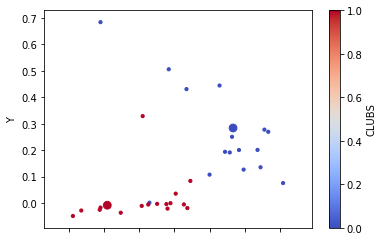

In [250]:
size = np.isin(np.array(zkc.index),[0,33]) * 50 + 10
zkc.plot.scatter('X', 'Y', c='CLUBS', s=size, colormap='coolwarm')

In [251]:
def SGCN_forward(A, X, W):
    # calculate SpectralRule = D**-0.5 * A_hat * D**-0.5 * X * W
    # based on https://towardsdatascience.com/how-to-do-deep-learning-on-graphs-with-graph-convolutional-networks-7d2250723780
    I = np.matrix(np.eye(A.shape[0]))
    A_hat = A+I
    D = np.array(np.sum(A_hat, axis=0))[0]
    D = np.matrix(np.diag(D))
    y = D**-1 * A_hat * D**-1 * X * W
    return y

def leaky_relu(x):
    return np.where(x > 0, x, x * 0.05)

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [252]:
SGCN_L1 = leaky_relu(SGCN_forward(A, X, W1))
SGCN_L2 = sigmoid(SGCN_forward(A, SGCN_L1, W2))
print(SGCN_L2)

[[0.49160806 0.50276904]
 [0.49512147 0.50130696]
 [0.49315817 0.49996432]
 [0.49542262 0.49883129]
 [0.4971036  0.5021761 ]
 [0.48623463 0.50563104]
 [0.48705769 0.50500445]
 [0.49714364 0.50035082]
 [0.49650569 0.50071363]
 [0.49290023 0.50353675]
 [0.49685567 0.50196894]
 [0.4720079  0.51850218]
 [0.49331982 0.49600556]
 [0.49740732 0.50069472]
 [0.49617987 0.49296387]
 [0.49532269 0.50151664]
 [0.47828367 0.50819139]
 [0.49466335 0.50011899]
 [0.48378277 0.49356558]
 [0.49636514 0.50070375]
 [0.49156117 0.49967308]
 [0.49717916 0.50205394]
 [0.49335936 0.50127291]
 [0.49082987 0.4951394 ]
 [0.48484468 0.48827464]
 [0.48721624 0.49111258]
 [0.49468254 0.50154095]
 [0.48896729 0.49349175]
 [0.4944867  0.49954048]
 [0.49425783 0.50041889]
 [0.4957309  0.50064893]
 [0.49165116 0.49515312]
 [0.48935504 0.49732884]
 [0.48848271 0.49824769]]


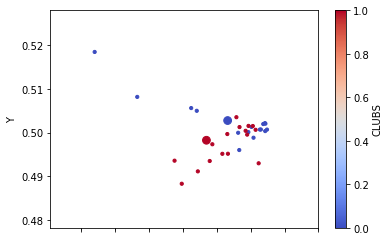

In [253]:
zkc = pd.DataFrame(SGCN_L2, columns=['X','Y'])
zkc['CLUBS'] = (pd.Series(clubs) == 'Officer').astype('int')
size = np.isin(np.array(zkc.index),[0,33]) * 50 + 10
zkc.plot.scatter('X', 'Y', c='CLUBS', s=size, colormap='coolwarm')